<h2 style="color: blue" align="center">Spaceship Titanic <h2/>

## Data Overview

**train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
<br>
**PassengerId**- A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
<br>
**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
<br>
**CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
<br>
**Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
<br>
**Destination** - The planet the passenger will be debarking to.
<br>
**Age** - The age of the passenger.
<br>
**VIP** - Whether the passenger has paid for special VIP service during the voyage.
<br>
**RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
<br>
**Name** - The first and last names of the passenger.
<br>
**Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
<br>
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [219]:
df_raw = pd.read_csv("data\\train.csv")
print("Shape before split: ",df_raw.shape)
df_raw.head()


Shape before split:  (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [220]:
X = df_raw.drop("Transported", axis=1)
y = df_raw["Transported"]

X_train, X_val, y_train, y_val= train_test_split(X,y,random_state=1337, test_size=0.2)

print("Train shape: ", X_train.shape)
print("Val shape: ", X_val.shape)

Train shape:  (6954, 13)
Val shape:  (1739, 13)


In [221]:
df_train = pd.concat((X_train, y_train), axis=1)
df_train.shape

(6954, 14)

## Data Understanding

In [222]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 6954 entries, 4049 to 3223
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6787 non-null   object 
 2   CryoSleep     6788 non-null   object 
 3   Cabin         6788 non-null   object 
 4   Destination   6812 non-null   object 
 5   Age           6810 non-null   float64
 6   VIP           6793 non-null   object 
 7   RoomService   6804 non-null   float64
 8   FoodCourt     6804 non-null   float64
 9   ShoppingMall  6798 non-null   float64
 10  Spa           6810 non-null   float64
 11  VRDeck        6813 non-null   float64
 12  Name          6805 non-null   object 
dtypes: float64(6), object(7)
memory usage: 760.6+ KB


In [223]:
X_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6810.000000,6804.000000,6804.000000,6798.000000,6810.000000,6813.000000
mean,28.844347,219.848471,460.488536,172.003678,313.217621,313.176281
std,14.583124,661.642078,1618.347967,612.051347,1146.283318,1150.679361
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,39.000000,79.000000,27.000000,64.750000,52.000000
max,79.000000,9920.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [224]:
X_train.isna().sum()

PassengerId       0
HomePlanet      167
CryoSleep       166
Cabin           166
Destination     142
Age             144
VIP             161
RoomService     150
FoodCourt       150
ShoppingMall    156
Spa             144
VRDeck          141
Name            149
dtype: int64

### I think we can easily assume that neither Name or PassengerID has nothing to do with being transported -> im going to drop both columns right away

In [225]:
X_train = X_train.drop(columns=["PassengerId", "Name"]).copy()
X_val =  X_val.drop(columns=["PassengerId", "Name"]).copy()

In [226]:
X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
4049,Earth,False,F/811/S,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0
7198,Europa,False,C/287/S,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0
538,Europa,True,C/21/P,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0
7371,Earth,False,G/1271/P,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0
4974,Mars,False,F/1019/S,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0


In [227]:
def get_cabin(row):
    if str(row).endswith("S"):
        return "Starboard"
    elif str(row).endswith("P"):
        return "Port"
    else:
        return "Unknown"
    
X_train["Cabin"] = X_train["Cabin"].apply(get_cabin)
X_train.head(3)
    

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
4049,Earth,False,Starboard,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0
7198,Europa,False,Starboard,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0
538,Europa,True,Port,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0


In [228]:
#performing same logic on val df without looking at it
X_val["Cabin"] = X_val["Cabin"].apply(get_cabin)

In [229]:
categorical_columns = ["HomePlanet", "CryoSleep", "Cabin","Destination", "VIP"]
numeric_columns = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

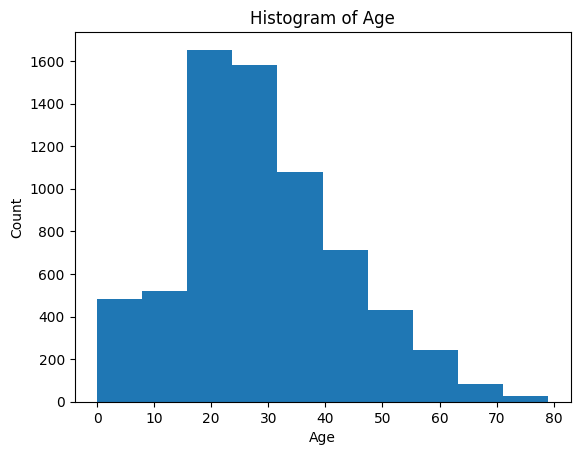

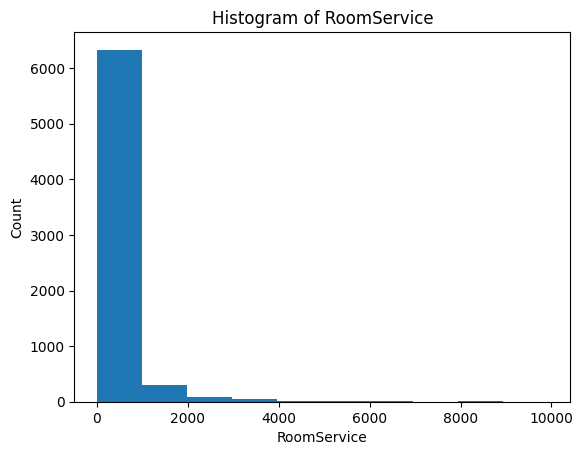

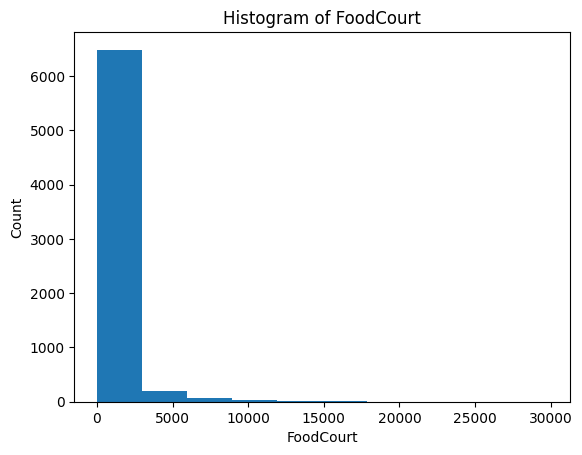

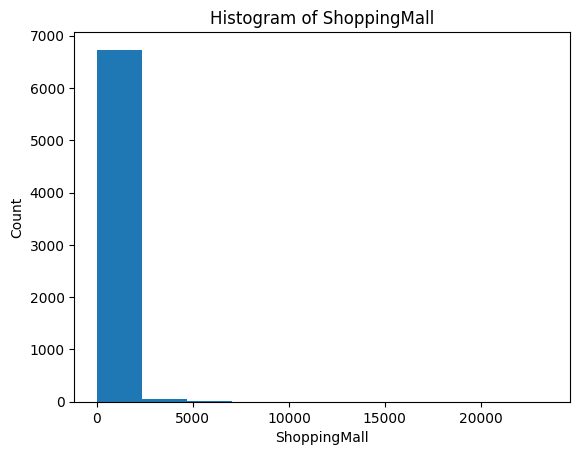

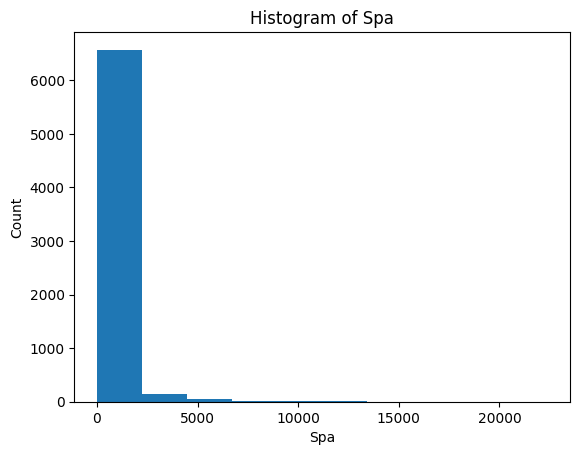

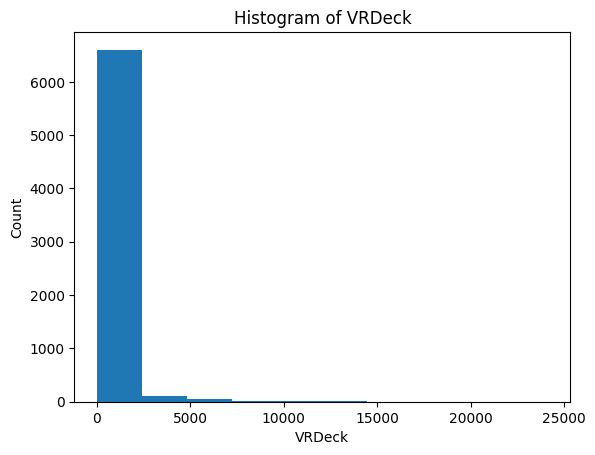

In [230]:
for col in numeric_columns:
    X_train[col].plot(kind="hist")
    plt.title(f"Histogram of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()
    


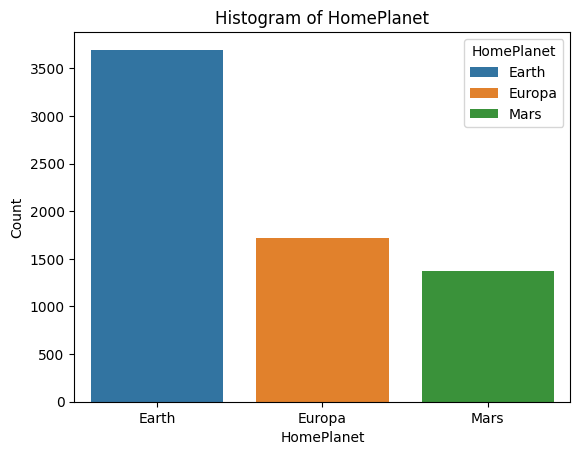

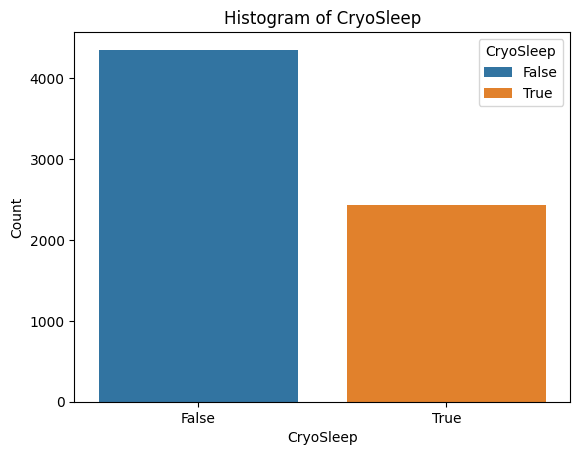

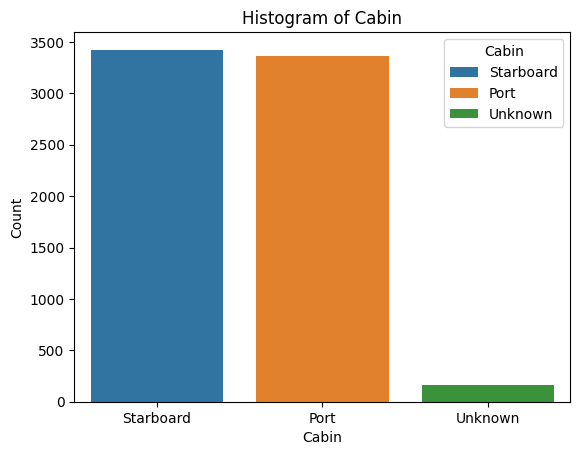

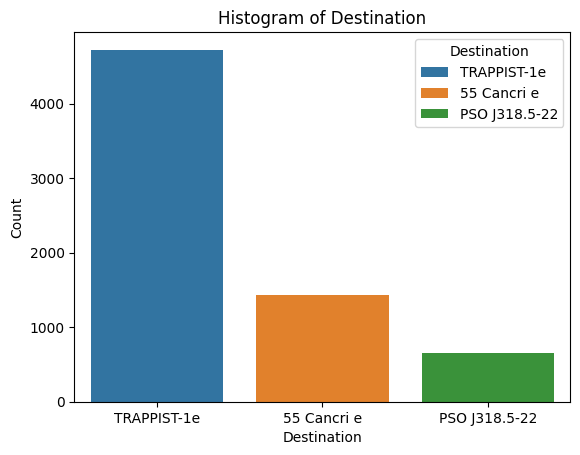

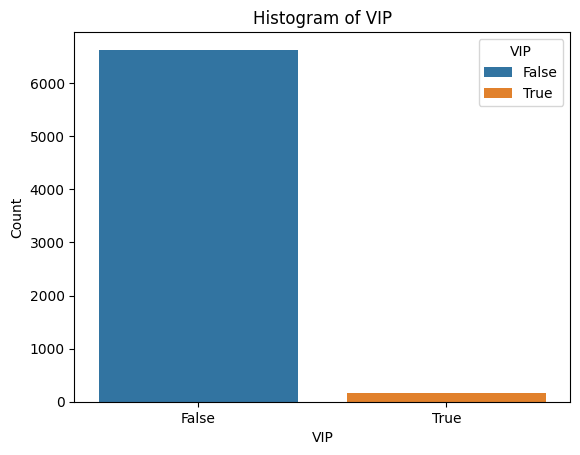

In [231]:
for col in categorical_columns:
    sns.countplot(data=X_train, x=col, palette='tab10', hue=col, legend=True)
    plt.title(f"Histogram of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()
    

#### Day 1 done - early exploration and data understanding. eta time spent: 45min

### Data Cleaning

In [232]:
df_train = df_train.drop(columns=["PassengerId", "Name"]).copy()


In [233]:
df_train[categorical_columns].isna().sum()

HomePlanet     167
CryoSleep      166
Cabin          166
Destination    142
VIP            161
dtype: int64

In [234]:
pct_vip_transported = df_train[df_train["VIP"] == True]["Transported"].sum() / df_train[df_train["VIP"] == True].shape[0]
pct_vip_transported

0.391304347826087

In [235]:
pct_nonvip_transported = df_train[df_train["VIP"] == False]["Transported"].sum() / df_train[df_train["VIP"] == False].shape[0]
pct_nonvip_transported

0.502714113389626

<Axes: xlabel='HomePlanet'>

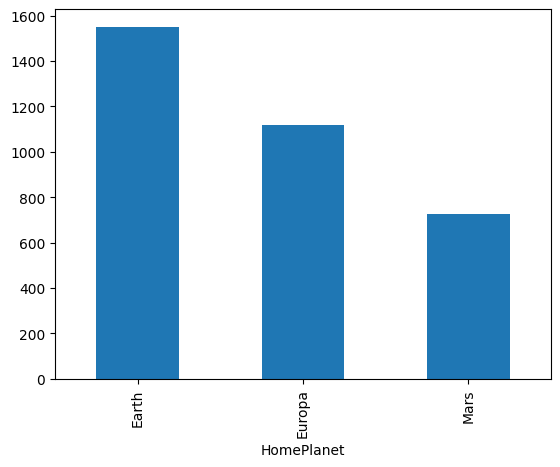

In [236]:
df_train.groupby("HomePlanet")["Transported"].sum().plot(kind='bar')

In [237]:
df_train["Cabin"] = df_train["Cabin"].apply(get_cabin)

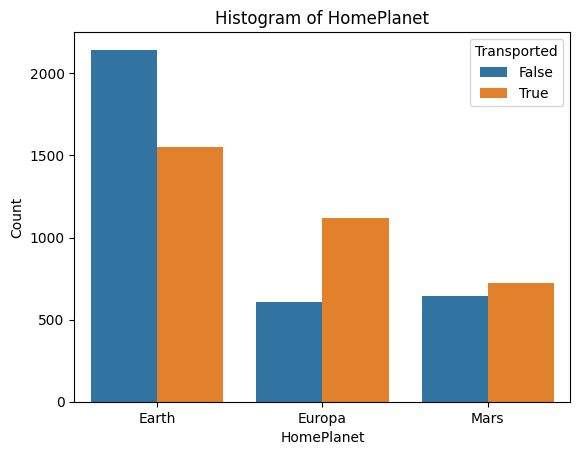

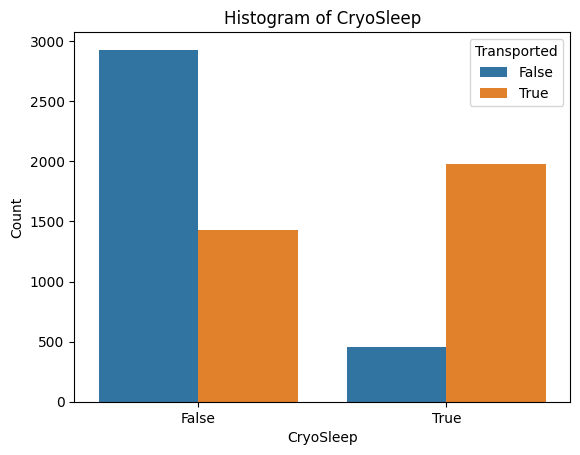

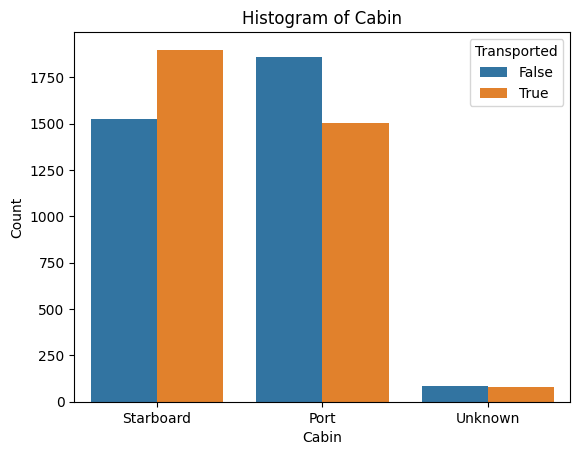

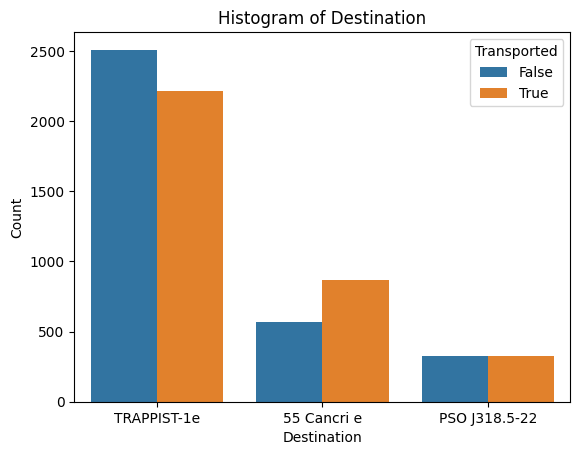

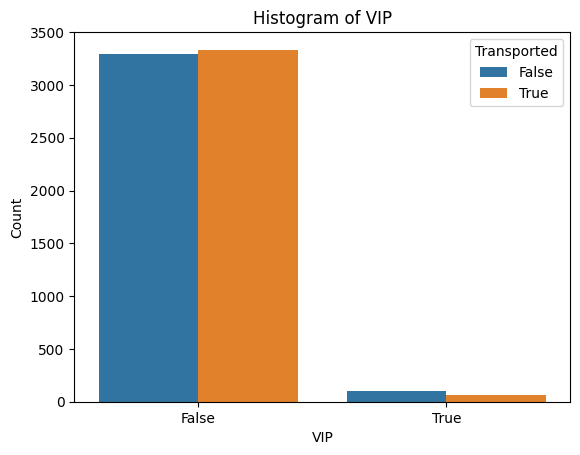

In [238]:
for col in categorical_columns:
    sns.countplot(data=df_train, x=col, palette='tab10', hue="Transported", legend=True)
    plt.title(f"Histogram of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    plt.show()

## NA values handling

#### Based on plots:
1. We can safely add "False" as default data to **VIP** column, as there is no significant difference.



In [239]:
df_train[categorical_columns].isna().sum()

HomePlanet     167
CryoSleep      166
Cabin            0
Destination    142
VIP            161
dtype: int64

In [240]:
df_train["VIP"] = df_train["VIP"].fillna("False")
df_train["VIP"].isna().sum()


0

## To future self:
If i had enough time to handle this, the best approach would be: count the median for people of NA, eg. 'HomePlanet', see other important columns like 'CryoSleep', "Destination" and "Transported" - and based on this evaluate and fill those missing values. But since this is a training task and the model is no going to production (well at least I hope there wont be any space titanic disasters in the near future) I shall go with the easiest approach -> fill up all the missing values with mode. I wont be deleting them, because there is little data.

In [241]:
mode_planet = df_train["HomePlanet"].mode()[0]
mode_cryo = df_train["CryoSleep"].mode()[0]
mode_destination = df_train["Destination"].mode()[0]

mode_planet

'Earth'

In [242]:
df_train["HomePlanet"] = df_train["HomePlanet"].fillna(mode_planet)
df_train["CryoSleep"] = df_train["CryoSleep"].fillna(mode_cryo)
df_train["Destination"] = df_train["Destination"].fillna(mode_destination)


C:\Users\USER\AppData\Local\Temp\ipykernel_21008\2601116422.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train["CryoSleep"] = df_train["CryoSleep"].fillna(mode_cryo)


In [243]:
df_train[categorical_columns].isna().sum()

HomePlanet     0
CryoSleep      0
Cabin          0
Destination    0
VIP            0
dtype: int64

In [244]:
df_train.isna().sum()

HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age             144
VIP               0
RoomService     150
FoodCourt       150
ShoppingMall    156
Spa             144
VRDeck          141
Transported       0
dtype: int64

### Based on the plots -> most frequent value in spendings was 0 -> that's why im using it to fill NA in numeric columns

In [245]:
df_train["ShoppingMall"] = df_train["ShoppingMall"].fillna(0)
df_train["RoomService"] = df_train["RoomService"].fillna(0)
df_train["FoodCourt"] = df_train["FoodCourt"].fillna(0)
df_train["Spa"] = df_train["Spa"].fillna(0)
df_train["VRDeck"] = df_train["VRDeck"].fillna(0)

In [246]:
df_train.isna().sum()

HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age             144
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64

In [247]:
df_train["Age"] = df_train["Age"].fillna(df_train["Age"].median())
df_train.isna().sum()

HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

In [248]:
## same logic for X_val
X_val["ShoppingMall"] = X_val["ShoppingMall"].fillna(0)
X_val["RoomService"] = X_val["RoomService"].fillna(0)
X_val["FoodCourt"] = X_val["FoodCourt"].fillna(0)
X_val["Spa"] = X_val["Spa"].fillna(0)
X_val["VRDeck"] = X_val["VRDeck"].fillna(0)

X_val["Age"] = X_val["Age"].fillna(df_train["Age"].median())

X_val["HomePlanet"] = X_val["HomePlanet"].fillna(mode_planet)
X_val["CryoSleep"] = X_val["CryoSleep"].fillna(mode_cryo)
X_val["Destination"] = X_val["Destination"].fillna(mode_destination)

C:\Users\USER\AppData\Local\Temp\ipykernel_21008\3295013921.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_val["CryoSleep"] = X_val["CryoSleep"].fillna(mode_cryo)


In [249]:
X_val["VIP"] = X_val["VIP"].fillna("False")

In [250]:
X_train = df_train.drop("Transported", axis=1)

In [251]:
X_train.shape, y_train.shape

((6954, 11), (6954,))

### Encoding and Preparing for Training

In [252]:
X_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
4049,Earth,False,Starboard,TRAPPIST-1e,20.0,False,0.0,187.0,712.0,0.0,0.0
7198,Europa,False,Starboard,55 Cancri e,32.0,True,0.0,48.0,0.0,3204.0,112.0
538,Europa,True,Port,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0
7371,Earth,False,Port,TRAPPIST-1e,10.0,False,0.0,0.0,0.0,0.0,0.0
4974,Mars,False,Starboard,TRAPPIST-1e,18.0,False,1744.0,0.0,8.0,8.0,0.0


In [253]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

In [254]:
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])

In [255]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
ohe.fit(X_train[["HomePlanet", "Destination"]])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [256]:

X_train_encoded = ohe.transform(X_train[["HomePlanet", "Destination"]])

In [257]:
X_val_enc = ohe.transform(X_val[["HomePlanet", "Destination"]])

### Model Training

In [258]:
y_train.value_counts() #no imbalance within classes

Transported
True     3479
False    3475
Name: count, dtype: int64

In [259]:
# models = [
#     (
#         "Logistic Regression", 
#         {"C": 1, "solver": 'liblinear'},
#         LogisticRegression(C=1, solver='liblinear'), 
#         (X_train_encoded, y_train),
#         (X_val_enc, y_val)
#     ),
#     (
#         "Random Forest", 
#         {"n_estimators": 30, "max_depth": 3},
#         RandomForestClassifier(n_estimators=30, max_depth=3), 
#         (X_train_encoded, y_train),
#         (X_val_enc, y_val)
#     ),
#     (
#         "XGBClassifier",
#         {"use_label_encoder": False, "eval_metric": 'logloss'},
#         XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
#         (X_train_encoded, y_train),
#         (X_val_enc, y_val)
#     )]

In [260]:
# reports = []

# for model_name, params, model, train_set, val_set in models:
#     X_train = train_set[0]
#     y_train = train_set[1]
#     X_val = val_set[0]
#     y_val = val_set[1]
    
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_val)
#     report = classification_report(y_val, y_pred, output_dict=True)
#     reports.append(report)

In [261]:
# import mlflow
# import mlflow.sklearn
# import mlflow.xgboost

In [262]:
# mlflow.set_experiment("Titanic SpaceShip")
# mlflow.set_tracking_uri("http://localhost:5000")

# for i, element in enumerate(models):
#     model_name = element[0]
#     params = element[1]
#     model = element[2]
#     report = reports[i]
    
#     with mlflow.start_run(run_name=model_name):        
#         mlflow.log_param("model", model_name)
#         mlflow.log_metric('accuracy', report['accuracy'])
#         # mlflow.log_metric('recall_class_1', report['1']['recall'])
#         # mlflow.log_metric('recall_class_0', report['0']['recall'])
#         mlflow.log_metric('f1_score_macro', report['macro avg']['f1-score'])        
        
#         if "XGB" in model_name:
#             mlflow.xgboost.log_model(model, "model")
#         else:
#             mlflow.sklearn.log_model(model, "model") 

## LR

In [266]:
model_lr = LogisticRegression()
model_lr.fit(X_train_encoded, y_train)

y_pred = model_lr.predict(X_val_enc)
y_pred_train = model_lr.predict(X_train_encoded)

class_report_train = classification_report(y_true=y_train, y_pred=y_pred_train)
class_report_val = classification_report(y_true=y_val, y_pred=y_pred)

print(class_report_train)
print("*"*30)
print(class_report_val)

              precision    recall  f1-score   support

       False       0.58      0.64      0.61      3475
        True       0.60      0.53      0.56      3479

    accuracy                           0.58      6954
   macro avg       0.59      0.58      0.58      6954
weighted avg       0.59      0.58      0.58      6954

******************************
              precision    recall  f1-score   support

       False       0.56      0.62      0.59       840
        True       0.60      0.54      0.57       899

    accuracy                           0.58      1739
   macro avg       0.58      0.58      0.58      1739
weighted avg       0.58      0.58      0.58      1739



## XGB

In [267]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_encoded, y_train)

y_pred_xgb = model_xgb.predict(X_val_enc)
y_pred_train_xgb = model_xgb.predict(X_train_encoded)

class_report_train_xgb = classification_report(y_true=y_train, y_pred=y_pred_train_xgb)
class_report_val_xgb = classification_report(y_true=y_val, y_pred=y_pred_xgb)

print(class_report_train_xgb)
print("*"*30)
print(class_report_val_xgb)

              precision    recall  f1-score   support

       False       0.61      0.48      0.54      3475
        True       0.57      0.70      0.63      3479

    accuracy                           0.59      6954
   macro avg       0.59      0.59      0.58      6954
weighted avg       0.59      0.59      0.58      6954

******************************
              precision    recall  f1-score   support

       False       0.58      0.47      0.52       840
        True       0.58      0.68      0.63       899

    accuracy                           0.58      1739
   macro avg       0.58      0.58      0.57      1739
weighted avg       0.58      0.58      0.58      1739



## Note: day 2 - break, overall time spent: 2:30 (45+1h45m)